# Clustering Spotify Songs

The dataset contains audio_features data to different types of songs. All songs were extracted using Spotify API. 
features:

Acousticness - The higher the value the more acoustic the song is.	
Danceability - The higher the value, the easier it is to dance to this song.	
Energy - The energy of a song - the higher the value, the more energtic. song	
Instrumentalness - The higher the value the greater likelihood the song contains no vocals.	
Liveness - The higher the value, the more likely the song is a live recording.	
Loudness (dB) - The higher the value, the louder the song.	
Speechiness - The higher the value the more spoken word the song contains.	
Valence - The higher the value, the more positive mood for the song.


The Objective here is to cluster the songs and understand which genres they belong to.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as hcd
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import hdbscan

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Define DataProcessing class

In [3]:
class DataProcessing:
    def __init__(self, file):
        '''creates train and test dataframe'''
        self.df = self._load_data(file)

    def _load_data(self, file):
        return pd.read_csv(file)

    def dataset_info(self, file, df):
        '''prints main information'''
        #df = self._load_data(file)
        print('\n{0:*^80}'.format(' Reading from the file {0} '.format(file)))
        print("\nit has {0} rows and {1} columns".format(*df.shape))
        print('\n{0:*^80}\n'.format(' It has the following columns '))
        print(df.columns)
        print('\n{0:*^80}\n'.format(' Description of quantitative columns'))
        print(df.describe(include=[np.number]))
        print('\n{0:*^80}\n'.format(' Description of categorical columns'))
        print(df.describe(include=['O']))

    def clean_data(self, df, columns_to_drop):
        '''removes columns'''
        df = df.drop(columns_to_drop, axis=1)
        return df

    def standard_scaler(self, df):
        '''scale df using standard scalar'''
        scaled = StandardScaler().fit_transform(df)
        df_scaled = pd.DataFrame(scaled, columns=df.columns)
        return df_scaled

## Define Clustering class

In [4]:
class Clustering:
    def k_means(self, df, n_clusters):
        '''predict clusters using kmeans'''
        cluster = KMeans(n_clusters=n_clusters)
        df["cluster"] = cluster.fit_predict(df[df.columns])
        return df
    
    def agglomerative_clustering(self, df, n_clusters, affinity, linkage):
        '''predict clusters using hierarchical clustering'''
        hc = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
        df['cluster'] = hc.fit_predict(df)
        return df
    
    def density_based_clustering(self, df, eps, metric, min_samples):
        '''predict clusters using dbscan'''
        dbscan_df = DBSCAN(eps=eps, metric=metric, min_samples=min_samples).fit(df)
        df["cluster"] = dbscan_df.fit_predict(df)                                                              
        return df
    
    def hierarchical_density_based_clustering(self, df, min_cluster_size):
        '''predict clusters using hdbscan'''
        clusterer_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        clusterer_hdbscan.fit(df)
        df["cluster"] = clusterer_hdbscan.fit_predict(df) 
        return df

## Define DimensionalityReduction class

In [5]:
class DimensionalityReduction:
    def pca_transform(self, df_scaled, n_components):
        '''dimensionality reduction using pca'''
        pca = PCA(n_components=n_components)
        pcomponents = pca.fit_transform(df_scaled)
        pca_df = pd.DataFrame(data = pcomponents, columns = ['PC1', 'PC2'])
        ratio = pca.explained_variance_ratio_
        return pca_df, ratio
        
    def tsne_transform(self, df, n_components):
        '''dimensionality reduction using tsne'''
        tsne = TSNE(n_components=n_components).fit_transform(df)
        return tsne

## Define Visualization class

In [6]:
class Visualization:
    def __init__(self):
        '''define style parameters'''
        sns.set(rc={'figure.figsize': (11.7, 6.27)})
        self.palette = "viridis"
        self.color = "darkblue"

    def plot_elbow_curve(self, df, num):
        '''plot elbow curve to choose number of clusters'''
        k = range(1, num)
        kmeans = [KMeans(n_clusters=i) for i in k]
        score = [kmeans[i].fit(df[df.columns]).score(df[df.columns]) for i in range(len(kmeans))]
        pl.plot(k, score)
        pl.xlabel('Number of Clusters')
        pl.ylabel('Score')
        pl.title('Elbow Curve')
        pl.show()

    def plot_pca(self, pca_df, df, cluster_column):
        '''scatterplot to visualize after pca transformation'''
        sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'],
                        hue=df[cluster_column], palette=self.palette)
        plt.xlabel('First principle component')
        plt.ylabel('Second principle component')
        plt.show()

    def plot_tsne(self, tsne_df, df, cluster_column):
        '''scatterplot to visualize after tsne transformation'''
        sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:, 1],
                        hue=df[cluster_column], palette=self.palette)
        plt.xlabel('First tsne component')
        plt.ylabel('Second tsne component')
        plt.show()

    def plot_dendrogram(self, df, metric, method):
        '''plot dendrogram to choose number of clusters'''
        plt.style.use('ggplot')
        hcd.set_link_color_palette(["#B061FF", "#7a0177"])
        hcd.dendrogram(hcd.linkage(df, metric=metric, method=method))
        plt.title('Dendrogram', size=20)
        plt.xlabel('Customers', size=15)
        plt.ylabel('Euclidean Distances', size=15)
        plt.show()

    def plot_clusters(self, df, cluster, cluster_features):
        '''plot clusters interpretation'''
        sns.set_style("whitegrid")
        bins = np.linspace(0, 1, 10)
        fig, ax = plt.subplots(1, 6, figsize=(15, 3))
        cluster_df = df[df.cluster == cluster]
        col = 0
        for feature in cluster_features:
            general = df.groupby(pd.cut(df[feature], bins)).size().reset_index(name='count')
            cluster = cluster_df.groupby(pd.cut(cluster_df[feature], bins)).size().reset_index(name='count')
            sns.barplot(data=general, x=feature, y='count', color='#efedf5', ax=ax[col])
            sns.barplot(data=cluster, x=feature, y='count', color='#54278f', ax=ax[col])
            ax[col].set_xticklabels(range(1, 10), fontsize=12)
            col += 1
        plt.show()

In [9]:
file = "./data/data1996.csv"
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness', 'tempo'] 

## Create Data object

In [15]:
data = DataProcessing(file)
df = data.df
df = df[cluster_features]
df.head()

,acousticness,danceability,instrumentalness,energy,speechiness,tempo
0,0.007460,0.477,0.211,0.688,0.0373,126.291
1,0.938000,0.223,0.693,0.567,0.5800,127.091
2,0.005560,0.517,0.783,0.646,0.1370,165.653
3,0.001930,0.335,0.256,0.849,0.3190,181.701
4,0.000174,0.286,0.837,0.728,0.0616,171.454


In [16]:
clustering = Clustering()
dimension = DimensionalityReduction()
plot = Visualization()

## Scaled dataset using Standard Scaler
 
Transforms each feature to a normal distribution with a mean of 0 and standard deviation of 1

In [17]:
scaled_df = data.standard_scaler(df)

# KMeans Clustering


Cluster size 8 looks most reasonable based on the Elbow Curve


1. Use Scaled dataset
2. Elbow_curve
3. K-Means with n_clusters
4. PCA visualize
5. TSNE visualize

## Plot Elbow Curve

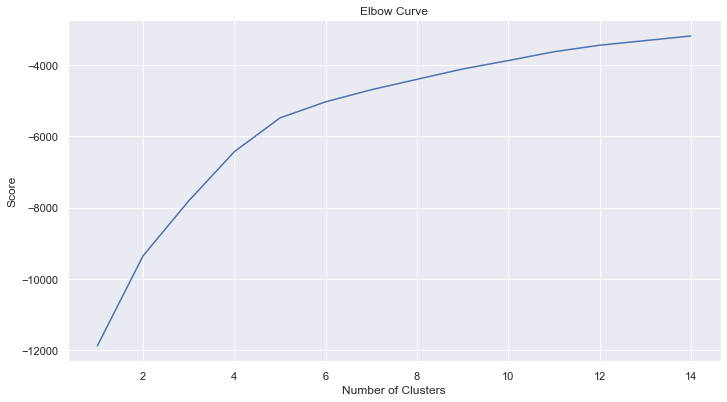

In [18]:
plot.plot_elbow_curve(scaled_df, 15)

## Create 8 Clusters

In [19]:
kmeans_df = clustering.k_means(scaled_df, 8)

## Visualization using PCA (K-Means)

In [20]:
kmeans_df_transform, ratio = dimension.pca_transform(kmeans_df, 2)

In [21]:
# explained_variance_ratio
ratio

array([0.53991441, 0.11128591])

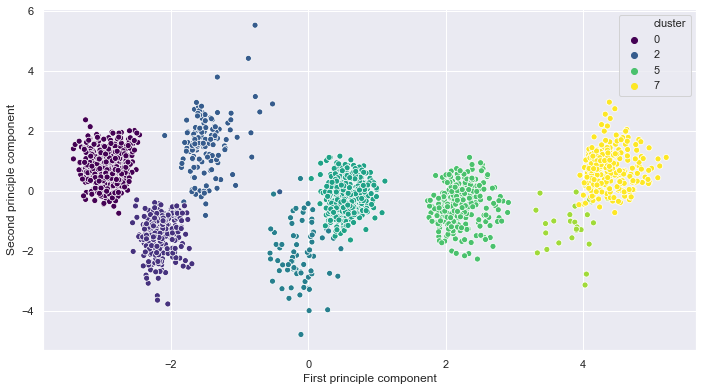

In [22]:
plot.plot_pca(kmeans_df_transform, kmeans_df, 'cluster')

## Visualization using TSNE (K-Means)

In [23]:
kmeans_tsne = dimension.tsne_transform(kmeans_df, 2)

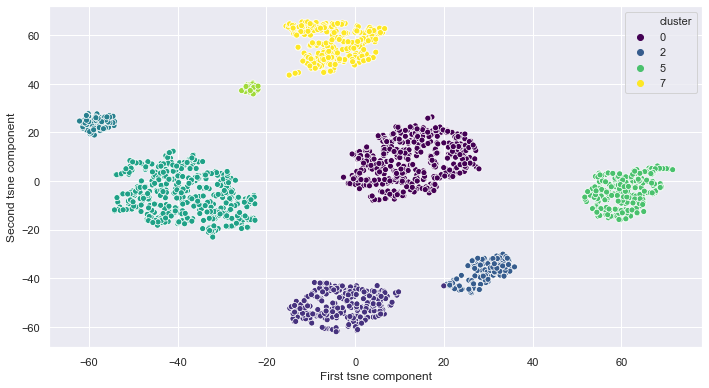

In [24]:
plot.plot_tsne(kmeans_tsne, kmeans_df, 'cluster')

## Visualization segments

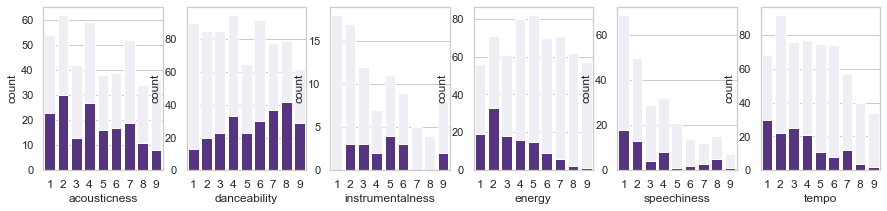

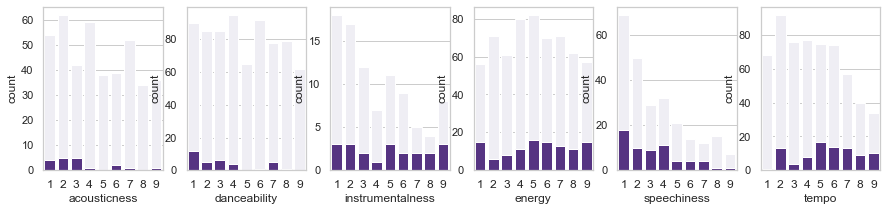

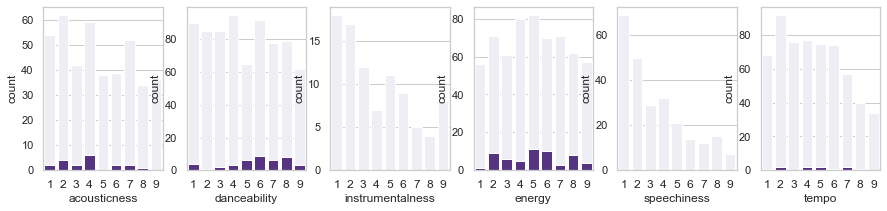

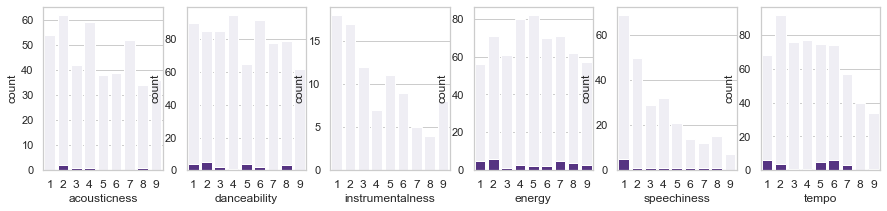

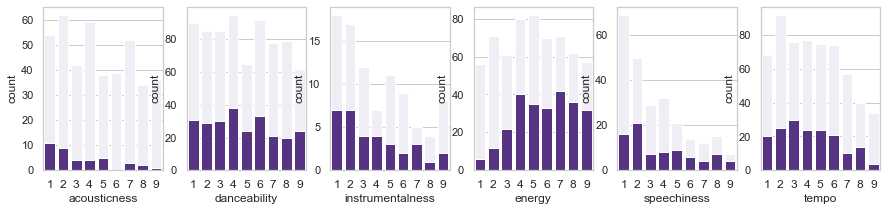

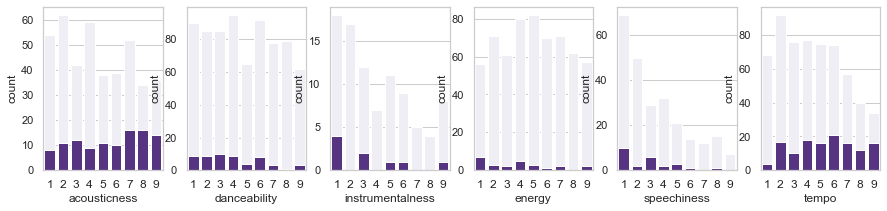

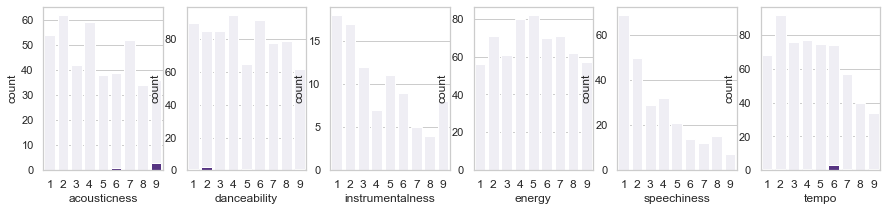

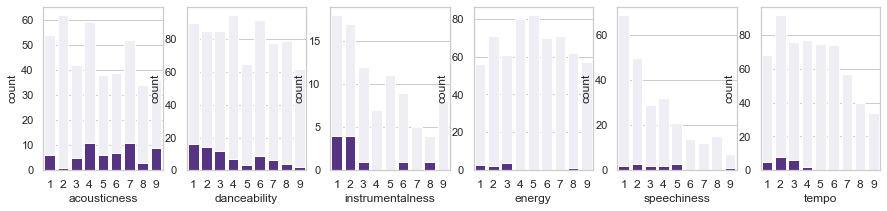

In [25]:
for i in np.sort(kmeans_df['cluster'].unique()):
    plot.plot_clusters(kmeans_df, i, cluster_features)

Cluster 1 HIGH: acousticness, danceability;

Cluster 2 instrumentalness, tempo, energy

Cluster 3 energy

Cluster 4 LOW:

Cluster 5 HIGH: energy, danceability

Cluster 6 acousticness, tempo

Cluster 7 LOW: 

Cluster 8 HIGH: acousticness;  LOW: instrumentalness, danceability, tempo

# Hierarchical Clustering
## Dendogram - Finding Optimal Number of Clusters

Cluster size 8 looks most reasonable based on the Dendogram.

1. Use Scaled dataset
2. Dendrogram
3. Agglomerative Clustering
4. PCA visualize
5. TSNE visualize

In [26]:
scaled_df = data.standard_scaler(df)
scaled_df.head()

,acousticness,danceability,instrumentalness,energy,speechiness,tempo
0,-0.981611,-0.740647,0.901130,0.372464,-0.372824,0.170255
1,2.249191,-2.372255,3.649116,-0.171388,6.246355,0.197193
2,-0.988207,-0.483701,4.162225,0.183689,0.843193,1.495676
3,-1.000811,-1.652806,1.157685,1.096103,3.063002,2.036053
4,-1.006907,-1.967565,4.470091,0.552251,-0.076443,1.691010


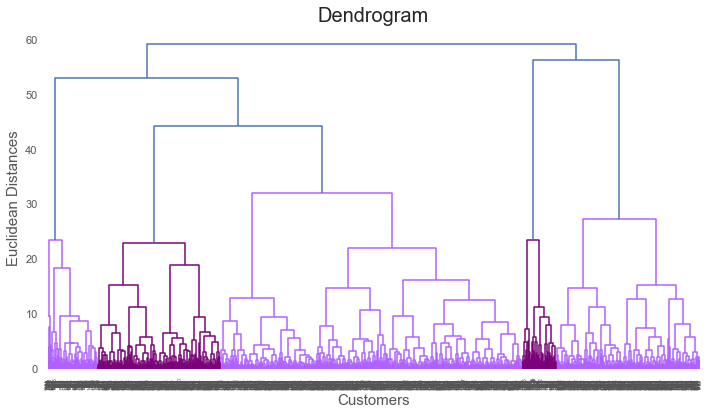

In [27]:
plot.plot_dendrogram(scaled_df, 'euclidean', 'ward')

In [28]:
hc_df = clustering.agglomerative_clustering(scaled_df, 6, 'euclidean', 'ward')

In [29]:
hc_df.cluster.unique()

array([4, 1, 2, 3, 5, 0])

##  Visualization using PCA (Hierarchical Clustering)

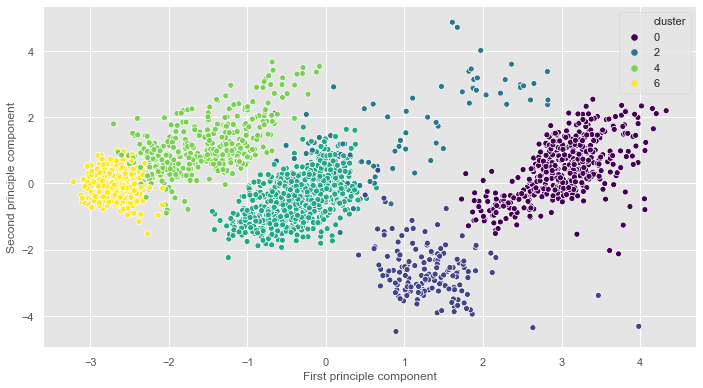

In [30]:
hc_df_transform, ratio = dimension.pca_transform(hc_df, 2)
plot.plot_pca(hc_df_transform, hc_df, 'cluster')

In [31]:
ratio

array([0.43864714, 0.17458115])

## Visualization using TSNE (Hierarchical Clustering)

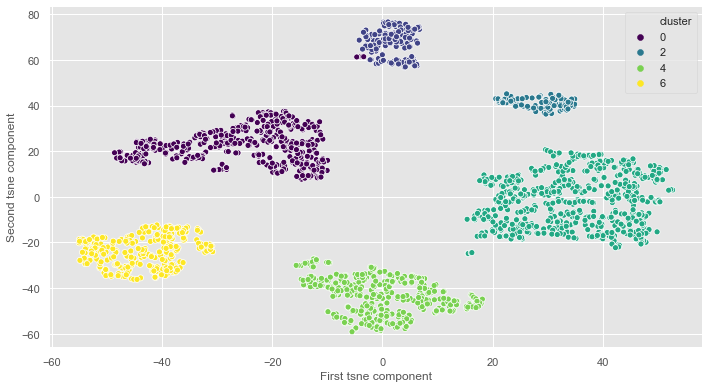

In [32]:
hc_tsne = dimension.tsne_transform(hc_df, 2)
plot.plot_tsne(hc_tsne, hc_df, 'cluster')

## Visualization segments

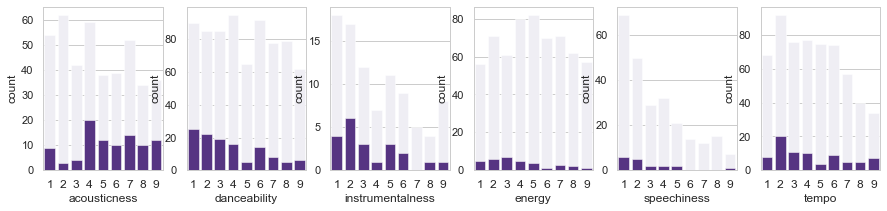

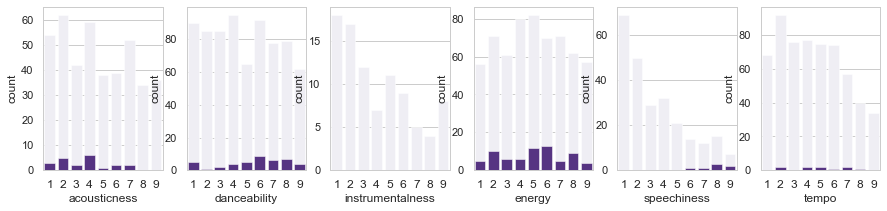

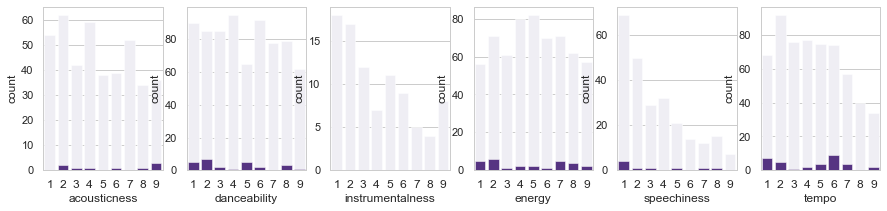

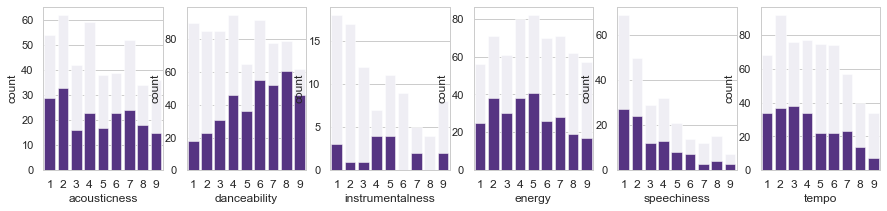

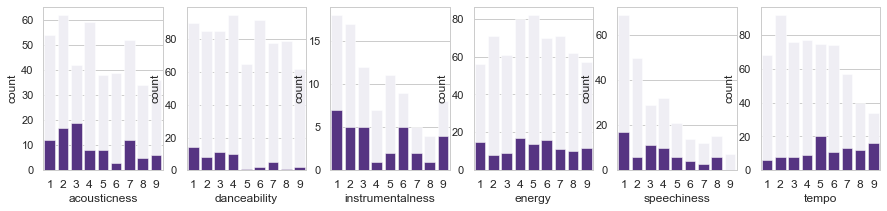

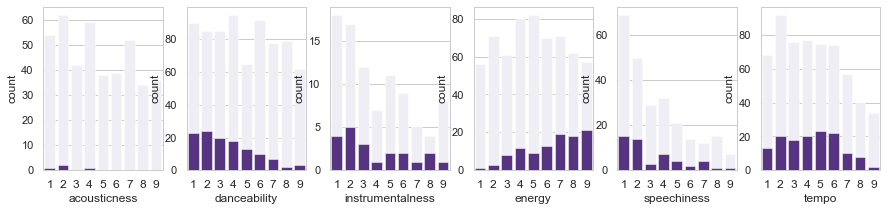

In [33]:
for i in np.sort(hc_df['cluster'].unique()):
    plot.plot_clusters(hc_df, i, cluster_features)

Cluster 1 HIGH: acousticness, instrumentalness; LOW: energy, speechiness => CLASSICAL

Cluster 2 energy

Cluster 3 LOW: energy, tempo

Cluster 4 HIGH: energy, danceability; MID: acousticness, speechiness => POP

Cluster 5 HIGH: acousticness, instrumentalness; MID: energy => JAZZ

Cluster 6 HIGH: energy, tempo; MID: acousticness, speechiness => ROCK

# DBSCAN

1. Use Scaled dataset
2. Density Based Clustering with parameters eps and min
3. PCA visualize
4. TSNE visualize

In [34]:
scaled_df = data.standard_scaler(df)
scaled_df.head()

,acousticness,danceability,instrumentalness,energy,speechiness,tempo
0,-0.981611,-0.740647,0.901130,0.372464,-0.372824,0.170255
1,2.249191,-2.372255,3.649116,-0.171388,6.246355,0.197193
2,-0.988207,-0.483701,4.162225,0.183689,0.843193,1.495676
3,-1.000811,-1.652806,1.157685,1.096103,3.063002,2.036053
4,-1.006907,-1.967565,4.470091,0.552251,-0.076443,1.691010


In [35]:
density_df = clustering.density_based_clustering(scaled_df, 0.8, 'euclidean', 6)

In [36]:
density_df.cluster.unique()

array([ 0, -1,  1,  2])

## Visualization using TSNE (DBSCAN)

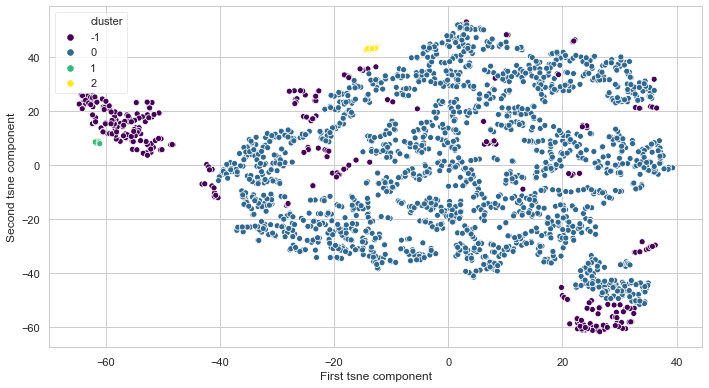

In [37]:
density_tsne = dimension.tsne_transform(density_df, 2)
plot.plot_tsne(density_tsne, density_df, 'cluster')

## Visualization using PCA (DBSCAN)

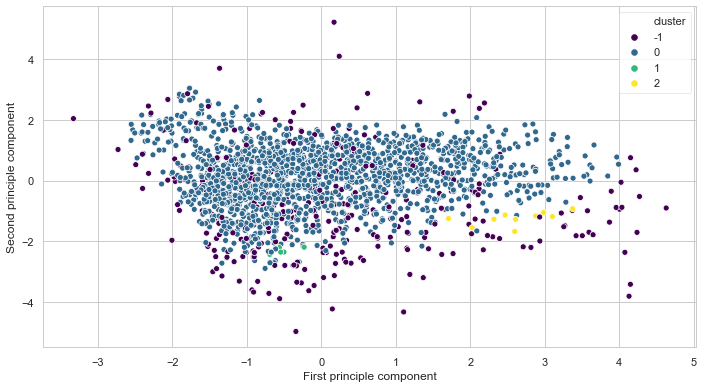

In [38]:
density_df_transform, ratio = dimension.pca_transform(density_df, 2)
plot.plot_pca(density_df_transform, density_df, 'cluster')

In [39]:
ratio

array([0.29278376, 0.21374397])

## Visualization segments

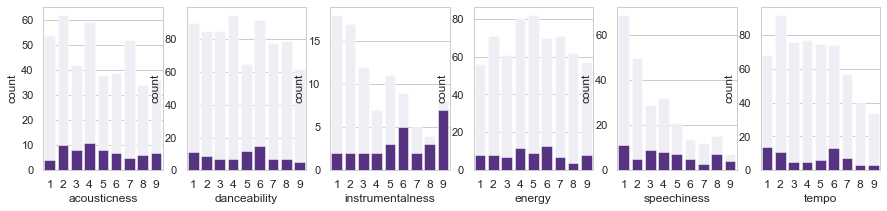

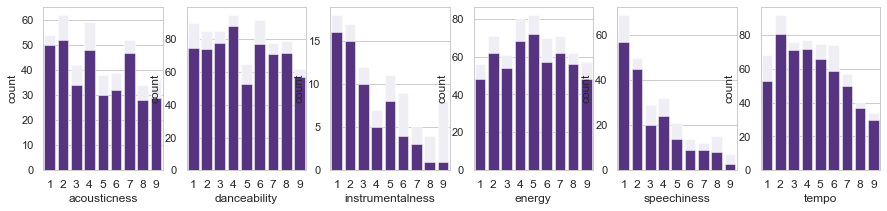

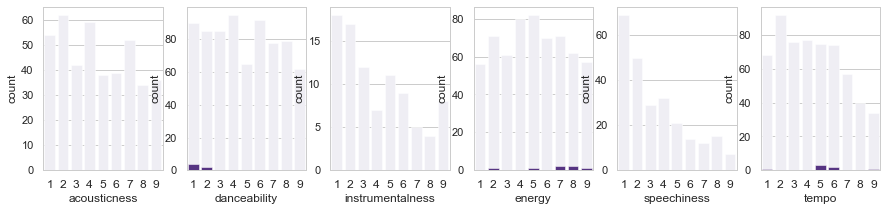

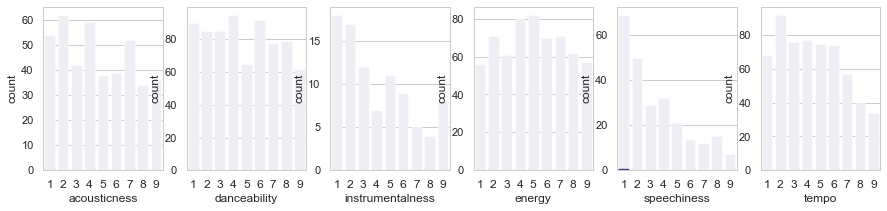

In [40]:
for i in np.sort(density_df['cluster'].unique()):
    plot.plot_clusters(density_df, i, cluster_features)

# HDBSCAN

1. Use Scaled dataset
2. Hierarchical Density-Based Clustering with parameter min_cluster_size
3. PCA visualize
4. TSNE visualiz

In [151]:
scaled_df = data.standard_scaler(df)
scaled_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,2.389082,-1.578245,-2.748012,4.492992,-0.779126,-5.635764,-0.376899,-1.829055,-2.042643
1,2.385671,-1.528525,-2.660396,4.598303,-0.870927,-4.503172,-0.255269,-1.781920,-2.043417
2,2.389082,-2.156243,-2.731881,4.477196,-0.673033,-5.676100,-0.324772,-1.724571,-1.983831
3,2.385671,-1.379364,-2.687721,4.503523,-0.736798,-4.774036,-0.196626,1.722682,-2.044964
4,2.382261,-1.826846,-2.474850,4.261309,-0.724155,-3.960467,-0.392103,-1.643191,-1.886327


In [152]:
hdbscan_df = clustering.hierarchical_density_based_clustering(scaled_df, 20)

In [153]:
hdbscan_df.cluster.unique()

array([-1,  1,  2,  0])

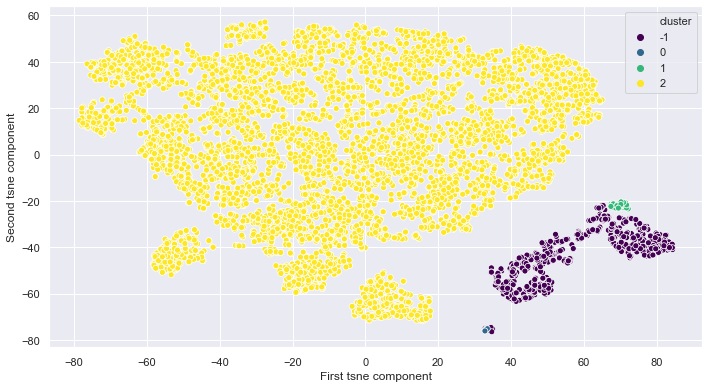

In [155]:
hdbscan_tsne = dimension.tsne_transform(hdbscan_df, 2)
plot.plot_tsne(hdbscan_tsne, hdbscan_df, 'cluster')

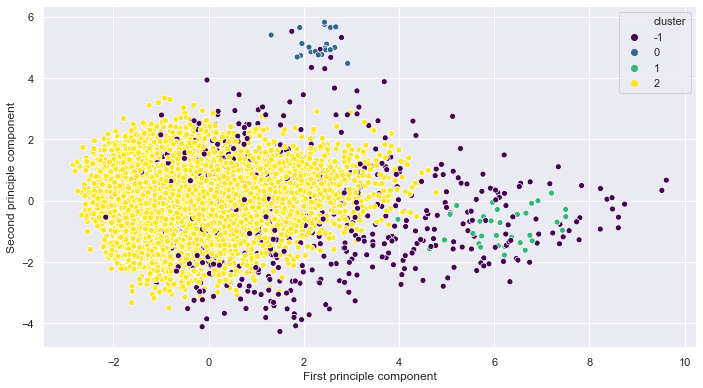

In [156]:
hdbscan_df_transform, ratio = dimension.pca_transform(hdbscan_df, 2)
plot.plot_pca(hdbscan_df_transform, hdbscan_df, 'cluster')

## Visualization segments

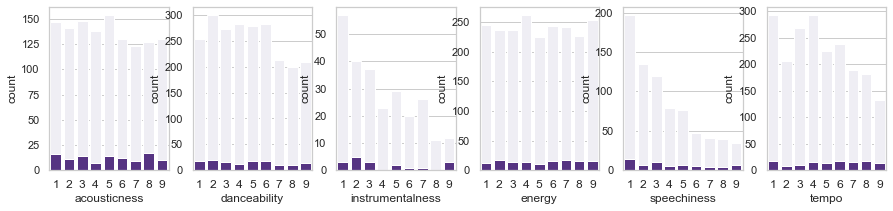

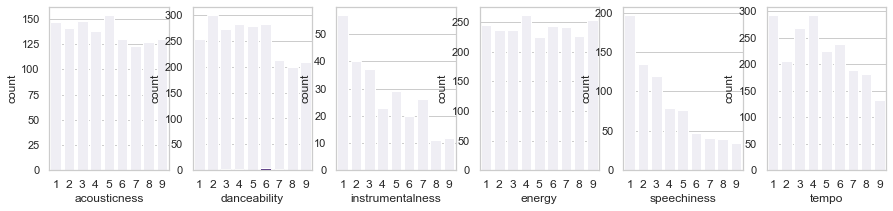

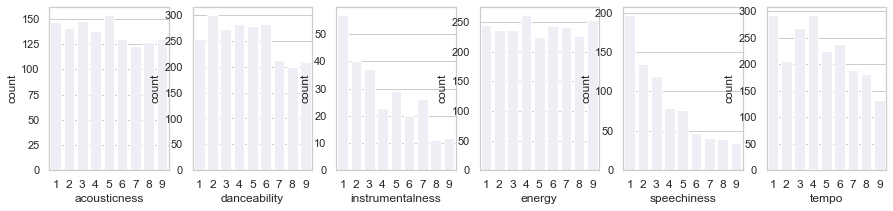

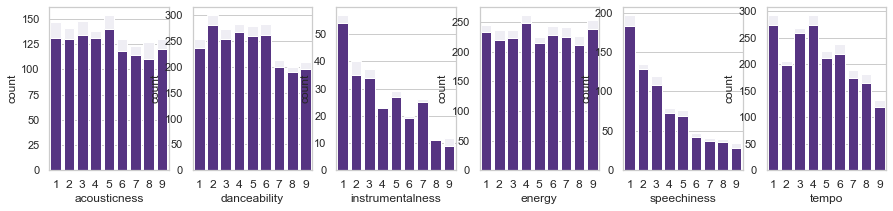

In [157]:
for i in np.sort(hdbscan_df['cluster'].unique()):
    plot.plot_clusters(hdbscan_df, i, cluster_features)

## Results: 

After Hierarchical Clustering I was able to identify 6 different clusters and recognize 4 genres: Classical, Pop, Jazz, Rock.
Let's check the results by extracting artists genre. Spotify API allows us to get features for artists such as genre. I will get a list of artists that were in the dataset1996 and get their genres. In this noteebook I will just load the csv.

In [42]:
artist_genres = pd.read_csv('./data/genre1996.csv')

In [44]:
artist_genres.head()

,artist_name,artist_id,artist_genre
0,TOOL,2yEwvVSSSUkcLeSTNyHKh8,alternative metal
1,Sublime,0EdvGhlC1FkGItLOWQzG4J,reggae fusion
2,Blackstreet,2P3cjUru4H3fhSXXNxE9kA,boy band
3,2Pac,1ZwdS5xdxEREPySFridCfh,g funk
4,Spice Girls,0uq5PttqEjj3IH1bzwcrXF,australian pop


In [50]:
df_genres = artist_genres.groupby('artist_genre').size().reset_index(name='count')
df_genres.sort_values(by=['count'], ascending=False).head()

,artist_genre,count
142,dance pop,23
38,banda,21
72,c-pop,21
14,alternative rock,21
12,alternative metal,18


In [56]:
def change_genre(x):
    if 'pop' in x:
        return 'pop'
    elif 'rock' in x or 'indie' in x or 'punk' in x:
        return 'rock'
    elif 'alternative' in x or 'hardcore' in x:
        return 'rock'
    elif 'metal' in x:
        return 'metal'
    elif 'hip hop' in x:
        return 'hip hop'
    elif 'classical' in x or 'classic' in x:
        return 'classical'
    elif 'country' in x:
        return 'folk'
    elif 'salsa' in x or 'rumba' in x or 'latin' in x:
        return 'dance'
    elif 'dance' in x or 'disco' in x or 'samba' in x or 'bachata' in x:
        return 'dance'
    elif 'funk' in x or 'r&b' in x:
        return 'funk'
    elif 'electronic' in x or 'house' in x:
        return 'electronic'
    elif 'jazz' in x or 'fusion' in x:
        return 'jazz'
    elif 'folk' in x or 'chanson' in x:
        return 'folk'
    else:
        return x

In [57]:
df_genres['genre'] = df_genres['artist_genre'].apply(change_genre)

In [58]:
top_genre = df_genres.groupby('genre').size().reset_index(name='count')
top_genre.sort_values(by=['count'], ascending=False).head(10)

,genre,count
94,pop,71
97,rock,64
60,folk,18
42,dance,14
69,hip hop,13
79,metal,11
32,classical,10
72,jazz,6
62,funk,4
54,electronic,3
